# Entanglement-assisted benchmarking

- With parallel CNOT



In [5]:
import numpy as np
import sys, json, copy, time, pickle, random
from concurrent.futures import ThreadPoolExecutor
import qiskit
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit_aer import StatevectorSimulator, AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error, amplitude_damping_error, ReadoutError
# from qiskit.providers.ibmq.managed import IBMQJobManager, ManagedJobSet
# from qiskit.providers.ibmq.apiconstants import ApiJobShareLevel
from qiskit.quantum_info.operators.symplectic import pauli
import matplotlib.pyplot as plt
from scipy.stats import sem, unitary_group
from scipy import sparse

# import EAB_submit_2 as EAB_submit
# import EAB_process
from statistics import stdev
import itertools
from qiskit.compiler import transpile

from qiskit.quantum_info import Pauli
from qiskit_ionq import IonQProvider
import os
sys.path.append(r"/Users/yzhu/yzhu_work/gates projects/EAB/EAB_code from Senrui")
import EAB_submit, EAB_process
from qubit_map import my_qubit_maps

## Additional functions

In [6]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

## Data generation

In [7]:

use_density_matrix = False # density matrix based / measurement based simulation

# choose one
use_ibmq = False
use_stabilizer_simulator = True # whether stabilizer simulator is used (valid only for Pauli noise)
use_density_matrix_sample = False # use density matrix simulation, but returns samples
use_state_vector_sample = False # use state vector simulation, which returns samples

# parameters: n, Lrange, C, shots
use_readout_error = True
shots = 2000
n = 2 # num of qubit
n_total = 2*n
# Lrange = list(range(2,39,4)) # len = 10
Lrange = [2**x for x in range(1,6)]
C = 20
batch = 1
gset = "Pauli"
q = my_qubit_maps['local']
repeat = [1 for k in Lrange] # not used
periodic = False # not used

# For specific IBM device structure
# TODO: put these in qubit_map.py
# q = {
#     0:0,
#     2:1,
#     1:3,
#     3:4,
#     4:2
# }
# q = {
#     0:0,
#     2:1,
#     1:2,
#     3:3,
#     4:4
# }

clifford_layer = 'XX'
# clifford_layer = 'Id'

# Simulation parameters
eps = 0.01# two parallel Cnot ~ 2%
# eps_amp = 0.025 # SPAM error at CNOT
eps_readout = 0.005 # readout bitflip ~ 1%
# eps_cross = 0.025 # SPAM error at CNOT

noise_model = NoiseModel()
# # noise_model.add_all_qubit_quantum_error(pauli_error([('I',1-eps),('X',eps)]),['id', 'x', 'y','z'])
noise_model.add_all_qubit_quantum_error(pauli_error([('II',(1-eps)**2),('XX',eps**2),('IX',eps*(1-eps)),('XI',eps*(1-eps))]),['cx'])

# # phase/amplitude damping error
# amp_noise_1q = amplitude_damping_error(eps_amp)
# noise_model.add_all_qubit_quantum_error(amp_noise_1q.tensor(amp_noise_1q),['cx'])

# # crosstalk between CNOTs (choose it to be ZZ)
# crosstalk_noise = pauli_error([('II',1-eps_cross),('ZZ',eps_cross)])
# for i in range(n-2):
#     noise_model.add_nonlocal_quantum_error(crosstalk_noise, ['cx'], [i,i+1], [i+1,i+2])
# noise_model.add_nonlocal_quantum_error(crosstalk_noise, ['cx'], [n-2,n-1], [n-1,0])
# noise_model.add_nonlocal_quantum_error(crosstalk_noise, ['cx'], [n-1,0], [0,1])

# readout error
if use_readout_error is True:
    p0given1 = eps_readout
    p1given0 = eps_readout
    readout_noise_1q = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
    noise_model.add_all_qubit_readout_error(readout_noise_1q)



if use_ibmq is False:
    filename = 'sim_eab_cnot_2022oct'
else:
    filename = 'exp_eab_cnot_2022oct'
    job_manager = IBMQJobManager()



# if use_density_matrix or use_density_matrix_sample:
#     backend = AerSimulator(method='density_matrix', noise_model=noise_model)
# elif use_state_vector_sample:
#     backend = AerSimulator(method='statevector', noise_model=noise_model)
# elif use_stabilizer_simulator:
#     backend = AerSimulator(method='stabilizer', noise_model=noise_model)
# elif use_ibmq:
#     provider = IBMQ.load_account()
#     backend = provider.get_backend('ibmq_manila')
# else:
#     assert 1==0

# print("EAB, ", "n=%d" % n)
# print("simulation method:", backend.configuration().description)

os.environ["IONQ_API_KEY"] = "5YIT8WaP7SCAtLap1uvzz8AQIM99BYqq"
my_api_key = os.getenv("IONQ_API_KEY")
provider = IonQProvider(my_api_key)
backend = provider.get_backend("ionq_simulator")



data = {}
token = ''.join(random.choice([str(j) for j in range(10)]) for i in range(10))
filename += '_' + token


# generate EAB circuit:
#Lrange: depth
#C=sample size per depth
# batch: 1??
#qubit_map=
#gset= Pauli
#repeat=[1,1,1,1,1]??
# periodic=False??

eab_data, eab_circ_all = EAB_submit.submit_eab(n,n_total,clifford_layer = clifford_layer,Lrange=Lrange,C=C,batch=batch, qubit_map=q,gset=gset,repeat=repeat,periodic=periodic,use_density_matrix=use_density_matrix)
print("created %d circuits" % len(eab_circ_all[0]))
data_batch = eab_data["batch_0"]
print("length of data_batch %d" %len(data_batch))

print(eab_circ_all[0][0]) # print a typical example
print (eab_circ_all[0][0].qasm())
# print(transpile(eab_circ_all[0][0],basis_gates=backend.configuration().basis_gates))
# print(transpile(eab_circ_all[0][0],optimization_level=3,basis_gates=backend.configuration().basis_gates,coupling_map=backend.configuration().coupling_map,initial_layout=q))

# sys.exit(0)

if use_density_matrix is True:
    job = backend.run(eab_circ_all[0], shots=1, max_parallel_experiments=0) 
elif use_ibmq is False:
    print ("here")
    job = backend.run(eab_circ_all[0], shots=shots, max_parallel_experiments=0,noise_model="harmony") 
else:
    job = backend.run(transpile(eab_circ_all[0],basis_gates=backend.configuration().basis_gates), shots=shots) 
result = job.result()
eab_data["result"] = [result.to_dict()]

eab_data["parameters"] = {}
eab_data["parameters"]['n'] = n 
eab_data["parameters"]['n_total'] = n_total
eab_data["parameters"]['shots'] = shots 
eab_data["parameters"]['Lrange'] = Lrange 
eab_data["parameters"]['C'] = C
eab_data["parameters"]['eps_readout'] = eps_readout
eab_data["parameters"]['repeat'] = repeat

eab_data['token'] = token

# if use_ibmq is False:
#     eab_data["result"] = [result]
# else:
#     eab_data["job_set_id"] = job_set_id

# test: data saving
# print(eab_data)
print(token)
# open ('data/' + filename, 'x')
# with open('/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/EAB(code from Senrui)/data/' + filename, 'wb') as outfile:
#     pickle.dump(eab_data, outfile)

# print(token)

created 100 circuits
length of data_batch 100
     ┌───┐           ░ ┌───┐┌───────────┐ ░ ┌───┐┌───────────┐ ░ ┌───┐ ░      »
q_0: ┤ H ├──■────────░─┤ X ├┤0          ├─░─┤ X ├┤0          ├─░─┤ Z ├─░───■──»
     ├───┤  │        ░ ├───┤│  Rxx(π/2) │ ░ ├───┤│  Rxx(π/2) │ ░ ├───┤ ░   │  »
q_1: ┤ H ├──┼────■───░─┤ Z ├┤1          ├─░─┤ Z ├┤1          ├─░─┤ Y ├─░───┼──»
     └───┘┌─┴─┐  │   ░ └───┘└───────────┘ ░ └───┘└───────────┘ ░ └───┘ ░ ┌─┴─┐»
q_2: ─────┤ X ├──┼───░─────────────────────────────────────────────────░─┤ X ├»
          └───┘┌─┴─┐ ░                                                 ░ └───┘»
q_3: ──────────┤ X ├─░─────────────────────────────────────────────────░──────»
               └───┘ ░                                                 ░      »
c: 4/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«     ┌───┐      ░ ┌─┐         
«q_0: ┤ H ├──────░─┤M├─────────
«     └───

/var/folders/6l/f5pw0tyx785dhvmqpb7282h00000gn/T/ipykernel_14440/3975056056.py:123: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.qasm()`` is deprecated as of qiskit 0.46. It will be removed in the 1.0.0 release. Instead use the qiskit.qasm2.dump() or qiskit.qasm2.dumps() function
  print (eab_circ_all[0][0].qasm())


7915552751


In [11]:
# for item in (eab_data["result"][0]['results']):
#     print (item)
# print (eab_data["result"][0]['results'][0]['data']['counts'])
# print (eab_data["result"][0]['results'][1]['data']['counts'])
# from qiskit.result import Result
# print ((eab_data["batch_0"][0]))
# print ((eab_data["batch_0"][99]))

# result_batch = Result.from_dict(eab_data["result"][0])
outcomes = result.get_counts(1)
# # print (outcomes.items()["0010"])
# print (outcomes)
print (outcomes)
print (result)

{'0000': 12, '0001': 14, '0010': 1495, '0100': 47, '0111': 139, '1000': 142, '1010': 5, '1011': 31, '1100': 3, '1101': 30, '1110': 82}
Result(backend_name='ionq_simulator', backend_version='0.0.1', qobj_id='None', job_id='09fb8de7-8beb-4f8b-b85b-74e9ed530420', success=True, results=[ExperimentResult(shots=2000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 5, '0x2': 9, '0x5': 14, '0x7': 138, '0x8': 105, '0xd': 1729}, probabilities={'0x0': 0.0025, '0x2': 0.005, '0x5': 0.0085, '0x7': 0.072, '0x8': 0.062, '0xd': 0.85}, metadata={'memory_slots': 4, 'global_phase': 0.0, 'n_qubits': 4, 'name': 'circuit-500', 'creg_sizes': [['c', 4]], 'clbit_labels': [['c', 0], ['c', 1], ['c', 2], ['c', 3]], 'qreg_sizes': [['q', 4]], 'qubit_labels': [['q', 0], ['q', 1], ['q', 2], ['q', 3]]}), header=QobjExperimentHeader(clbit_labels=[['c', 0], ['c', 1], ['c', 2], ['c', 3]], creg_sizes=[['c', 4]], global_phase=0.0, memory_slots=4, n_qubits=4, name='circuit-500', qreg_sizes=[['q', 4]], qu

Similarly, in the estimation $\hat{p}_{XI}=\hat{p}_{XX}=0.0025$ due to degeneracy.

## Data analysis

In [4]:
# import EAB_process
'''Use these if read from file'''
# token = "1011327761"
# filename = "sim_eab_cnot_2022oct_" + token
# with open('data/' + filename, 'rb') as infile:
#     eab_data = pickle.load(infile)



n = eab_data["parameters"]['n']
n_total = eab_data["parameters"]['n_total'] 
shots = eab_data["parameters"]['shots'] 
Lrange = eab_data["parameters"]['Lrange']
C = eab_data["parameters"]['C'] 
eps_readout = eab_data["parameters"]['eps_readout'] 
repeat = eab_data["parameters"]['repeat']

'''Specify a set of Pauli you want to estimate'''
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = n)] #full

# pauli_request_list = ['XX']

eab_result = EAB_process.process_EAB(batch, Lrange, eab_data, pauli_request_list, repeat=repeat, periodic=periodic,use_density_matrix=use_density_matrix)

# fidelity_list[1..512] = [0.99,0.98,...]

raw_fidelity_list = eab_result["fidelity_list"]


# sys.exit(0)

fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*n):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process.fit_EAB(Lrange, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err
# print(fidelity_list)

# print(stdev_list)
print("Parameters: n = %d, C = %d, " % (n,C), "L = ", str(Lrange))

if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))



Parameters: n = 2, C = 20,  L =  [2, 4, 8, 16, 32]
Measurement based simulation, shots = 2000
Measurement bitflip rate = 0.005000
Total error =  0.030505369473220023
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.015482745906000406 0.0006212016811898653
YI 0.046253797411797026 0.002085180075078686
ZI 0.044520639033180376 0.0020368368127758308
IX 0.016022915937473403 0.0006811710262440361
XX 0.030803785915117787 0.0013207698505124958
YX 0.046415320574239805 0.002166599661555424
ZX 0.04523889897258504 0.0020708515723224467
IY 0.046473849632192143 0.002079824629987424
XY 0.04457848190199387 0.002038020862313699
YY -0.00034648698053496574 0.00023927962722653697
ZY 0.01508417478884605 0.0006706546695761496
IZ 0.04629268745533943 0.0020202799987988503
XZ 0.045131846855825164 0.0020078688781424298
YZ 0.015810682209998927 0.000762891677696839
ZZ 0.03032257195746435 0.00131485075487044


Note that, the estimation suffers from some degeneracy. E.g., $\lambda_{IZ}$ and $\lambda_{ZZ}$ cannot be individually addressed. Only their geometric mean is estimated and reported. This issue is detailed in [The learnability of Pauli noise](https://arxiv.org/abs/2206.06362).

In [5]:
error_list = fidelity_to_error(fidelity_list,n)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])

Label / Pauli error rates
II 0.96949463052678
XI -9.291972727287767e-05
YI 0.0033900236931566977
ZI 1.0902251084833614e-05
IX -8.68934955792211e-05
XX 0.015107820756424167
YX 2.923079476496726e-05
ZX 0.004135747231904706
IY 0.003999469261535542
XY -3.494942108939192e-05
YY 2.0586502664107775e-05
ZY -2.466790295511251e-05
IZ 2.8498119519188014e-05
XZ 0.003842971026682289
YZ -2.4441087398408e-06
ZZ 0.00018199449111983707


<BarContainer object of 15 artists>

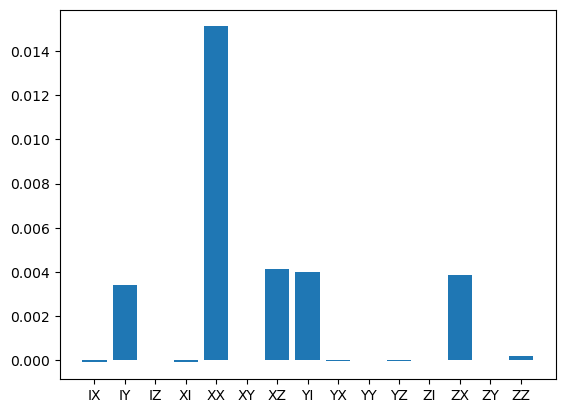

In [6]:
plt.bar([label for label in error_list.keys()][1:],[error_list[label] for label in error_list.keys()][1:])

Similarly, in the estimation $\hat{p}_{XI}=\hat{p}_{XX}=0.0025$ due to degeneracy.

In [7]:
# True value for this specific noise model
def f_true(P):
    ans = 0.0
    for Pi in P:
        if Pi == 'Z' or Pi == 'Y':
            ans += 2*eps
    return ans
def p_true(P):
    if P == "XI" or P == "IX":
        return eps
    else:
        return 0.0

print("Label / True infidelity/ True Pauli error")
for P in pauli_request_list:
    print(P[::-1]," ",f_true(P)," ",p_true(P))

Label / True infidelity/ True Pauli error
II   0.0   0.0
XI   0.0   0.01
YI   0.02   0.0
ZI   0.02   0.0
IX   0.0   0.01
XX   0.0   0.0
YX   0.02   0.0
ZX   0.02   0.0
IY   0.02   0.0
XY   0.02   0.0
YY   0.04   0.0
ZY   0.04   0.0
IZ   0.02   0.0
XZ   0.02   0.0
YZ   0.04   0.0
ZZ   0.04   0.0


In [8]:
plot_dic={}
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], (1-fidelity_list[pauli_label])-f_true(pauli_label))
    plot_dic[pauli_label[::-1]]=(1-fidelity_list[pauli_label])-f_true(pauli_label)

II 0.0
XI 3.3201099060020667e-06
YI -0.0005111871584372145
ZI -0.00033004173029758596
IX -2.4565815118782197e-05
XX -6.963699108464283e-06
YX -0.0005570673255199492
ZX -0.0003608693658354416
IY 0.009727975101719095
XY 0.009694016999577743
YY -0.010444557418704058
ZY -0.010403352430777467
IZ 0.009820235421757268
XZ 0.009793584856456001
YZ -0.010338551447318066
ZZ -0.010319975755474907


In [9]:
print (plot_dic)

{'II': 0.0, 'XI': 3.3201099060020667e-06, 'YI': -0.0005111871584372145, 'ZI': -0.00033004173029758596, 'IX': -2.4565815118782197e-05, 'XX': -6.963699108464283e-06, 'YX': -0.0005570673255199492, 'ZX': -0.0003608693658354416, 'IY': 0.009727975101719095, 'XY': 0.009694016999577743, 'YY': -0.010444557418704058, 'ZY': -0.010403352430777467, 'IZ': 0.009820235421757268, 'XZ': 0.009793584856456001, 'YZ': -0.010338551447318066, 'ZZ': -0.010319975755474907}


In [10]:
# plot_c100={}
# plot_c100=plot_dic

In [11]:
# plot_c30={}
# plot_c30=plot_dic

In [12]:
# plot_c20={}
# plot_c20=plot_dic

In [13]:
# plot_c10={}
# plot_c10=plot_dic

In [14]:
# plot_c5={}
# plot_c5=plot_dic

In [15]:
# plot_c3={}
# plot_c3=plot_dic

In [16]:
plt.figure(figsize=(15,10))
plt.plot(list(plot_c100.keys()),list(plot_c100.values()),"*",markersize=10)
plt.plot(list(plot_c30.keys()),list(plot_c30.values()),"*",markersize=10)
plt.plot(list(plot_c20.keys()),list(plot_c20.values()),"*",markersize=10)
plt.plot(list(plot_c10.keys()),list(plot_c10.values()),"*",markersize=10)
plt.plot(list(plot_c5.keys()),list(plot_c5.values()),"*",markersize=10)
# plt.plot(list(plot_c3.keys()),list(plot_c3.values()),"*",markersize=10)
plt.legend(["C=100","C=30","C=20","C=10","C=5"])
plt.ylabel("f_measure - f_true",fontsize=20)
plt.savefig("eps=0.01 single CNOT EAB.pdf",format="pdf",dpi=500)

NameError: name 'plot_c100' is not defined

<Figure size 1080x720 with 0 Axes>

In [ ]:
print (eab_result)

In [8]:
for i in range (1,3):
    print (i)

1
2
